# The Battle of Neighborhoods
Capstone project of IBM Data Science course

## Apply Machine Learning technique and Location Data to understand your market and make a strategic decision

Import necessary libraries

In [14]:
import pandas as pd
import numpy as np
import bs4 as bs
import requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

import json # library to handle JSON files

!pip install geocoder
import geocoder

!pip install folium==0.5
import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler

import geopy

import matplotlib.pyplot as plt

!pip install wget
import wget

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: 

We make use of a json file that comes with all the borough's name, neighborhood's name and their corresponding latitude and longitude

In [15]:
url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
filename = wget.download(url)
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [16]:
with open(filename) as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [17]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [18]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [19]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe

The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [20]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [21]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [22]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


Convert each neighborhood to zip/postal code using their corresponding latitude and longitude

In [23]:
import geopy

def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='IBM_capstone')

neighborhoods['Postalcode'] = neighborhoods.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')


Extract the first Postalcode in the Postalcode column

In [24]:
neighborhoods['Postalcode']=neighborhoods['Postalcode'].astype('str').str[0:5]

neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude,Postalcode
0,Bronx,Wakefield,40.894705,-73.847201,10466
1,Bronx,Co-op City,40.874294,-73.829939,10475
2,Bronx,Eastchester,40.887556,-73.827806,10466
3,Bronx,Fieldston,40.895437,-73.905643,10471
4,Bronx,Riverdale,40.890834,-73.912585,10463
5,Bronx,Kingsbridge,40.881687,-73.902818,10463
6,Manhattan,Marble Hill,40.876551,-73.910660,10463
7,Bronx,Woodlawn,40.898273,-73.867315,10470
8,Bronx,Norwood,40.877224,-73.879391,10467
9,Bronx,Williamsbridge,40.881039,-73.857446,10467


Convert Postalcode column to numbers

In [25]:
neighborhoods['Postalcode'] = neighborhoods['Postalcode'].apply(pd.to_numeric)

Check if there is any duplicate in the Postalcode column

In [26]:
neighborhoods['Postalcode'].value_counts()

10314    10
10306     9
10304     7
10309     7
10301     7
         ..
10022     1
10024     1
10025     1
10028     1
7206      1
Name: Postalcode, Length: 146, dtype: int64

Combine rows of neighbordhood with the same postal code

In [27]:
g = neighborhoods['Postalcode']
d = neighborhoods.groupby(g, sort=False).first()
d['Neighborhood'] = neighborhoods['Neighborhood'].dropna().groupby(g).agg(','.join)
neighborhoods = d.reset_index()

Take a look of the dataframe

In [28]:
neighborhoods

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,10466,Bronx,"Wakefield,Eastchester,Edenwald",40.894705,-73.847201
1,10475,Bronx,Co-op City,40.874294,-73.829939
2,10471,Bronx,"Fieldston,North Riverdale",40.895437,-73.905643
3,10463,Bronx,"Riverdale,Kingsbridge,Marble Hill,Spuyten Duyvil",40.890834,-73.912585
4,10470,Bronx,Woodlawn,40.898273,-73.867315
...,...,...,...,...,...
141,10017,Manhattan,Turtle Bay,40.752042,-73.967708
142,11104,Queens,"Sunnyside Gardens,Blissville",40.745652,-73.918193
143,11379,Queens,Middle Village,40.716415,-73.881143
144,10468,Bronx,Kingsbridge Heights,40.870392,-73.901523


Double check if there is any more duplicate postal code rows

In [29]:
neighborhoods['Postalcode'].value_counts()

11004    1
10306    1
11361    1
11360    1
11103    1
        ..
11692    1
11435    1
11434    1
11433    1
11355    1
Name: Postalcode, Length: 146, dtype: int64

#### Next we collect household median income data

Scrape the New York City Household Median Income per Zip code from Zipatlas website

In [30]:
url='http://zipatlas.com/us/ny/new-york/zip-code-comparison/median-household-income.htm'

Get page content

In [31]:
page = requests.get(url)

User BeautifulSoup parser to parse the webpage

In [32]:
soup = bs.BeautifulSoup(page.text, 'html.parser')

Find table using find_all method. There are many tables on the page and we use the rules and frame attributes to find the correct table.

In [33]:
table = soup.find_all('table',attrs={"rules": "all","frame":"box"})

Find all rows in the table and append each rows into a list

Pass the list to the dataframe

Remove the first row and reset index

In [34]:
table_rows = table[0].find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    #print(td)
    row = [tr.text for tr in td]
    l.append(row)
median_income=pd.DataFrame(l, columns=["Number", "Postalcode","Location", "City", "Population", "Median household income", "National Rank"])
median_income.drop([0], inplace=True)
median_income.reset_index(drop=True,inplace=True)
median_income.head(10)

,Number,Postalcode,Location,City,Population,Median household income,National Rank
0,1.,10007,"40.713973, -74.008336","New York, New York","3,522","$112,947.00",#132
1,2.,10280,"40.708501, -74.016828","New York, New York","6,614","$108,536.00",#157
2,3.,10162,"40.769298, -73.949942","New York, New York","1,726","$108,416.00",#158
3,4.,10004,"40.691870, -74.014109","New York, New York","1,225","$101,868.00",#238
4,5.,10069,"40.775551, -73.989689","New York, New York","1,403","$88,091.00",#507
5,6.,10282,"40.717017, -74.015566","New York, New York","1,574","$86,066.00",#591
6,7.,10006,"40.707970, -74.013610","New York, New York","1,447","$81,334.00",#766
7,8.,10022,"40.758615, -73.967752","New York, New York","30,642","$80,406.00",#820
8,9.,10005,"40.705390, -74.008988","New York, New York",884,"$79,517.00",#860
9,10.,10024,"40.786307, -73.970694","New York, New York","61,414","$78,066.00",#935


Drop unnecessary columns

In [35]:
median_income.drop(columns=['Number','City','National Rank', 'Location'], inplace=True)
median_income.head(10)

,Postalcode,Population,Median household income
0,10007,"3,522","$112,947.00"
1,10280,"6,614","$108,536.00"
2,10162,"1,726","$108,416.00"
3,10004,"1,225","$101,868.00"
4,10069,"1,403","$88,091.00"
5,10282,"1,574","$86,066.00"
6,10006,"1,447","$81,334.00"
7,10022,"30,642","$80,406.00"
8,10005,884,"$79,517.00"
9,10024,"61,414","$78,066.00"


For illustration purpose, we focus on Asian restaurants/market

Scrape the New York City Percentage of Asians in New Yrok per Zip code from Zipatlas website

In [36]:
url='http://zipatlas.com/us/ny/new-york/zip-code-comparison/percentage-asian-population.htm'

Get page content

In [37]:
page = requests.get(url)

User BeautifulSoup parser to parse the webpage

In [38]:
soup = bs.BeautifulSoup(page.text, 'html.parser')

Find table using find_all method. There are many tables on the page and we use the rules and frame attributes to find the correct table.

In [39]:
table = soup.find_all('table',attrs={"rules": "all","frame":"box"})

Find all rows in the table and append each rows into a list

Pass the list to the dataframe

Remove the first row and reset index

In [40]:
table_rows = table[0].find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
asian_percentage=pd.DataFrame(l, columns=["Number", "Postalcode","Location", "City", "Population", "Asian percentage", "National Rank"])
asian_percentage.drop([0], inplace=True)
asian_percentage.reset_index(drop=True,inplace=True)
asian_percentage.head(10)

,Number,Postalcode,Location,City,Population,Asian percentage,National Rank
0,1.,10170,"40.752625, -73.975877","New York, New York",1,100.00 %,#1
1,2.,10002,"40.715952, -73.985870","New York, New York","84,870",49.24 %,#45
2,3.,10013,"40.720067, -74.004829","New York, New York","25,042",45.87 %,#54
3,4.,10048,"40.711665, -74.012417","New York, New York",55,32.72 %,#120
4,5.,10038,"40.709336, -74.002943","New York, New York","15,574",31.77 %,#129
5,6.,10005,"40.705390, -74.008988","New York, New York",884,22.85 %,#245
6,7.,10018,"40.754969, -73.992126","New York, New York","4,255",22.04 %,#263
7,8.,10280,"40.708501, -74.016828","New York, New York","6,614",19.00 %,#332
8,9.,10069,"40.775551, -73.989689","New York, New York","1,403",18.67 %,#337
9,10.,10012,"40.725639, -73.998090","New York, New York","26,000",18.27 %,#354


Drop unnecessary columns

In [41]:
asian_percentage.drop(columns=['Number', 'Location', 'City', 'National Rank', 'Population'], inplace=True)
asian_percentage.head(10)

,Postalcode,Asian percentage
0,10170,100.00 %
1,10002,49.24 %
2,10013,45.87 %
3,10048,32.72 %
4,10038,31.77 %
5,10005,22.85 %
6,10018,22.04 %
7,10280,19.00 %
8,10069,18.67 %
9,10012,18.27 %


Merge median income dataframe and asian percentage, key is Postalcode

In [42]:
income_asian = pd.merge(median_income, asian_percentage, on="Postalcode")
income_asian.head(10)

,Postalcode,Population,Median household income,Asian percentage
0,10007,"3,522","$112,947.00",10.64 %
1,10280,"6,614","$108,536.00",19.00 %
2,10162,"1,726","$108,416.00",3.36 %
3,10004,"1,225","$101,868.00",12.24 %
4,10069,"1,403","$88,091.00",18.67 %
5,10282,"1,574","$86,066.00",13.02 %
6,10006,"1,447","$81,334.00",8.98 %
7,10022,"30,642","$80,406.00",6.58 %
8,10005,884,"$79,517.00",22.85 %
9,10024,"61,414","$78,066.00",4.26 %


Check if there is any NA values in the dataframe

In [43]:
df1 = income_asian[income_asian.isna().any(axis=1)]
df1

,Postalcode,Population,Median household income,Asian percentage


Remove dollar sign, comma, percentage sign and .00 from the values

In [44]:
income_asian['Asian percentage'] = income_asian['Asian percentage'].replace({'%': ''}, regex=True)

cols = ['Population', 'Median household income', 'Asian percentage']
income_asian[cols] = income_asian[cols].replace({'\$': '', ',': ''}, regex=True)
income_asian['Median household income'] = income_asian['Median household income'].replace({'.00$':''}, regex=True)

Convert all values to string

Remove all leading and trailing spaces in all columns

Convert all values to numeric values

In [45]:
income_asian.astype(str)
cols = ['Postalcode', 'Population', 'Median household income','Asian percentage']
income_asian[cols] = income_asian[cols].apply(lambda x: x.str.strip())
income_asian[cols] = income_asian[cols].apply(pd.to_numeric)
income_asian.head(10)

,Postalcode,Population,Median household income,Asian percentage
0,10007,3522,112947,10.64
1,10280,6614,108536,19.00
2,10162,1726,108416,3.36
3,10004,1225,101868,12.24
4,10069,1403,88091,18.67
5,10282,1574,86066,13.02
6,10006,1447,81334,8.98
7,10022,30642,80406,6.58
8,10005,884,79517,22.85
9,10024,61414,78066,4.26


Statistical exploratory analysis of the dataframe

In [46]:
income_asian.describe()

,Postalcode,Population,Median household income,Asian percentage
count,47.000000,47.000000,47.000000,47.000000
mean,10045.765957,32539.744681,50437.680851,12.549574
std,64.454640,27801.326203,30777.585512,17.082874
min,10001.000000,1.000000,0.000000,0.000000
25%,10013.500000,5434.500000,25261.000000,3.125000
50%,10026.000000,26408.000000,49733.000000,7.120000
75%,10037.500000,54920.500000,73948.000000,14.015000
max,10282.000000,102078.000000,112947.000000,100.000000


The minimum of Median household income and Asian percentage is zero and we would like to find it out.

Sort the column Asian percentage

In [47]:
dd = income_asian.sort_values(by=['Asian percentage'])
dd

,Postalcode,Population,Median household income,Asian percentage
46,10171,1,0,0.00
43,10020,1,0,0.00
33,10037,16984,26561,0.47
41,10039,21737,17370,0.61
40,10030,25847,17970,0.71
42,10035,32702,14896,0.91
35,10031,60221,24285,1.27
31,10034,41756,29479,1.77
29,10033,58259,31348,1.77
38,10026,30377,22491,1.91


Remove rows with missing value

In [48]:
income_asian.dropna(inplace=True)

Remove rows with zero median household income

In [49]:
income_asian=income_asian[income_asian['Median household income']!=0]
income_asian

,Postalcode,Population,Median household income,Asian percentage
0,10007,3522,112947,10.64
1,10280,6614,108536,19.00
2,10162,1726,108416,3.36
3,10004,1225,101868,12.24
4,10069,1403,88091,18.67
5,10282,1574,86066,13.02
6,10006,1447,81334,8.98
7,10022,30642,80406,6.58
8,10005,884,79517,22.85
9,10024,61414,78066,4.26


In [50]:
income_asian.describe()

,Postalcode,Population,Median household income,Asian percentage
count,43.000000,43.000000,43.000000,43.000000
mean,10040.511628,35565.348837,55129.558140,10.630465
std,61.359352,27136.703998,27796.677252,10.796996
min,10001.000000,884.000000,14896.000000,0.470000
25%,10012.500000,15887.500000,28692.000000,3.485000
50%,10025.000000,30642.000000,55869.000000,7.120000
75%,10035.500000,57213.500000,76518.500000,12.630000
max,10282.000000,102078.000000,112947.000000,49.240000


Plot each column in boxplot

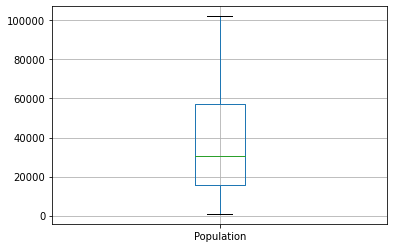

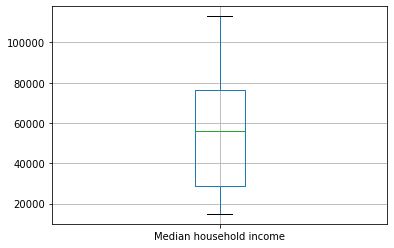

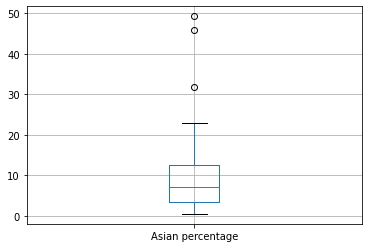

In [51]:
cols=['Population', 'Median household income', 'Asian percentage']
for x in cols:
    plt.figure()
    income_asian.boxplot(column=x)

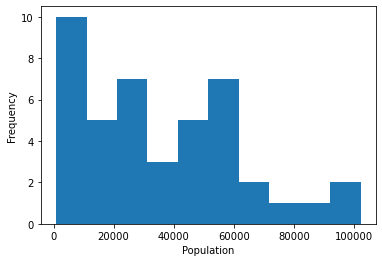

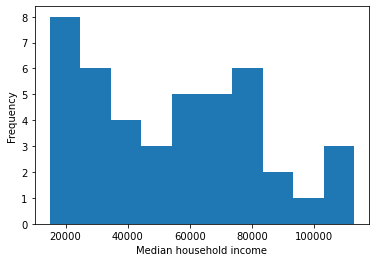

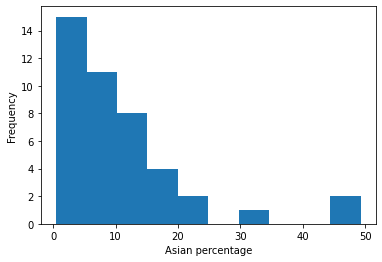

In [52]:
for x in cols:
    plt.figure()
    income_asian[x].plot.hist()
    plt.xlabel(x)

Append latitude and longitude columns from neighborhoods dataframe to income_asian dataframe

In [53]:
nyc_data = pd.merge(income_asian, neighborhoods, on="Postalcode")
nyc_data.head()

,Postalcode,Population,Median household income,Asian percentage,Borough,Neighborhood,Latitude,Longitude
0,10022,30642,80406,6.58,Manhattan,Sutton Place,40.760280,-73.963556
1,10005,884,79517,22.85,Manhattan,Financial District,40.707107,-74.010665
2,10024,61414,78066,4.26,Manhattan,Upper West Side,40.787658,-73.977059
3,10028,44987,77565,5.01,Manhattan,Yorkville,40.775930,-73.947118
4,10128,59856,70031,6.68,Manhattan,Carnegie Hill,40.782683,-73.953256


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [54]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [55]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, postalcode in zip(nyc_data['Latitude'], nyc_data['Longitude'], nyc_data['Borough'], nyc_data['Neighborhood'], nyc_data['Postalcode']):
    label = '{}, {}, {}'.format(postalcode, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [56]:
CLIENT_ID = '05KHEHGAUVAEEWVVCG134NG3XC5J0AON1IKXKLE4G05HOMXO' # your Foursquare ID
CLIENT_SECRET = 'R0NBCIROLWDXNOCZDDD2BNF1OHRV0G3YDRCIVO2ZFCDSFCSZ' # your Foursquare Secret
ACCESS_TOKEN = "ERM3ZZZVRZEV2TMGSTTKG2U4TJJVRYRD5AKFRNVCO0R0H4MR" # your Foursquare access token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('ACCESS_TOKEN:' + ACCESS_TOKEN)

Your credentails:
CLIENT_ID: 05KHEHGAUVAEEWVVCG134NG3XC5J0AON1IKXKLE4G05HOMXO
CLIENT_SECRET:R0NBCIROLWDXNOCZDDD2BNF1OHRV0G3YDRCIVO2ZFCDSFCSZ
ACCESS_TOKEN:ERM3ZZZVRZEV2TMGSTTKG2U4TJJVRYRD5AKFRNVCO0R0H4MR


#### Let's create a function to get the top 100 venues of all the neighborhoods in New York City within a radius of 500 meters 

In [57]:
def getNearbyVenues(names, latitudes, longitudes, postalcodes, radius=500):
    
    venues_list=[]
    for name, lat, lng, pcode in zip(names, latitudes, longitudes, postalcodes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postalcode', 'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _nyc_venues_.

In [58]:
nyc_venues = getNearbyVenues(names=nyc_data['Neighborhood'],
                                   latitudes=nyc_data['Latitude'],
                                   longitudes=nyc_data['Longitude'],
                                postalcodes=nyc_data['Postalcode']
                                  )

Sutton Place
Financial District
Upper West Side
Yorkville
Carnegie Hill
Turtle Bay
West Village
Murray Hill,Tudor City
Gramercy
Chelsea,Flatiron
Noho
Greenwich Village,Little Italy
Midtown South
Roosevelt Island
Manhattan Valley
Hudson Yards
Clinton,Midtown
East Village,Stuyvesant Town
Tribeca,Soho,Civic Center
Washington Heights
Inwood
Lincoln Square
Hamilton Heights
Chinatown,Lower East Side
Manhattanville,Morningside Heights
East Harlem
Central Harlem
Lenox Hill


#### Let's check the size of the resulting dataframe

In [59]:
print(nyc_venues.shape)
nyc_venues.head()

(2728, 9)


,Postalcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,10022,Sutton Place,40.76028,-73.963556,Equinox East 61st Street,4adf1930f964a5208a7721e3,40.761151,-73.961958,Gym
1,10022,Sutton Place,40.76028,-73.963556,The Jeffrey Craft Beer & Bites,4ff74eeae4b0f08304f382fc,40.760907,-73.963058,Beer Garden
2,10022,Sutton Place,40.76028,-73.963556,Katagiri,4a9af345f964a520bb3320e3,40.760951,-73.965502,Grocery Store
3,10022,Sutton Place,40.76028,-73.963556,The Pleasure Chest,5231c56d11d2087e09bc7d5f,40.761423,-73.963562,Adult Boutique
4,10022,Sutton Place,40.76028,-73.963556,Earth Yoga NYC,4ac259d0f964a520ca9820e3,40.761271,-73.962045,Yoga Studio


Since we would like to focus on Asian restaurant, let's only extract Asian restaurant

In [60]:
nyc_asian = nyc_venues[nyc_venues["Venue Category"].str.contains("Asian Restaurant")]
print(nyc_asian.shape)
nyc_asian

(11, 9)


,Postalcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
64,10022,Sutton Place,40.760280,-73.963556,Fusha Asian Cuisine,4b0b4b45f964a520063023e3,40.759086,-73.962620,Asian Restaurant
241,10024,Upper West Side,40.787658,-73.977059,Joe’s Steam Rice Roll,5fb174f3d415002aca5ab932,40.784068,-73.977884,Asian Restaurant
309,10028,Yorkville,40.775930,-73.947118,Peng's Noodle Folk,579fb23f498e7f9f1b7bd04c,40.777258,-73.949110,Asian Restaurant
554,10017,Turtle Bay,40.752042,-73.967708,Mighty Bowl,59723de1033693233be0f8fe,40.750970,-73.971456,Asian Restaurant
586,10017,Turtle Bay,40.752042,-73.967708,Gai Chicken & Rice,5ceea403270ee7002ce9199a,40.752716,-73.973340,Asian Restaurant
901,10011,"Chelsea,Flatiron",40.744035,-74.003116,TAO Downtown,523c7e56498ef9332c5ce675,40.742539,-74.003812,Asian Restaurant
1049,10003,Noho,40.723259,-73.988434,Duckedup,5744f4ad498e346b596e9fa3,40.720436,-73.988194,Asian Restaurant
1076,10003,Noho,40.723259,-73.988434,Ramen Ishida,591b9e948496ca6e22cdd3f6,40.719635,-73.988366,Asian Restaurant
2011,10034,Inwood,40.867684,-73.921210,UNIQUE,5d7c34d0f290e100081f09ca,40.866967,-73.921010,Asian Restaurant
2256,10002,"Chinatown,Lower East Side",40.715618,-73.994279,Ling Kee Malaysian Beef Jerky,4b89ac72f964a520e94a32e3,40.714713,-73.991538,Asian Restaurant


## Analyze New York City neighorboods by postalcode

Convert Venue category into dummy/indicator variables

In [61]:
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Postalcode'] = nyc_venues['Postalcode'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Postalcode,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10022,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


And let's examine the new dataframe size

In [62]:
nyc_onehot.shape

(2728, 330)

In [63]:
nyc_onehot_asian = nyc_onehot[["Postalcode","Asian Restaurant"]].groupby('Postalcode').sum().reset_index()
nyc_onehot_asianp = nyc_onehot_asian.rename(columns={"Asian Restaurant":"Number of Asian Restaurant"})
nyc_onehot_asianp

,Postalcode,Number of Asian Restaurant
0,10002,2
1,10003,2
2,10005,0
3,10009,0
4,10010,0
5,10011,1
6,10012,0
7,10013,0
8,10014,0
9,10016,0


Append the number of Asian Restaurants column to nyc_data dataframe

In [64]:
nyc_data = pd.merge(nyc_data, nyc_onehot_asianp, on="Postalcode")
nyc_data.head()

,Postalcode,Population,Median household income,Asian percentage,Borough,Neighborhood,Latitude,Longitude,Number of Asian Restaurant
0,10022,30642,80406,6.58,Manhattan,Sutton Place,40.760280,-73.963556,1
1,10005,884,79517,22.85,Manhattan,Financial District,40.707107,-74.010665,0
2,10024,61414,78066,4.26,Manhattan,Upper West Side,40.787658,-73.977059,1
3,10028,44987,77565,5.01,Manhattan,Yorkville,40.775930,-73.947118,1
4,10128,59856,70031,6.68,Manhattan,Carnegie Hill,40.782683,-73.953256,0


#### Let's check the rating of the first Asian restaurant

In [65]:
VENUE_ID = '5d7c34d0f290e100081f09ca'

url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&oauth_token={}&v={}'.format(
    VENUE_ID,
    CLIENT_ID, 
    CLIENT_SECRET,
    ACCESS_TOKEN,
    VERSION)
            
# make the GET request
results = requests.get(url).json()["response"]["venue"]
results

{'id': '5d7c34d0f290e100081f09ca',
 'name': 'UNIQUE',
 'contact': {},
 'location': {'address': '586 W 207th St',
  'lat': 40.866967,
  'lng': -73.92101,
  'labeledLatLngs': [{'label': 'display', 'lat': 40.866967, 'lng': -73.92101}],
  'postalCode': '10034',
  'cc': 'US',
  'city': 'New York',
  'state': 'NY',
  'country': 'United States',
  'formattedAddress': ['586 W 207th St',
   'New York, NY 10034',
   'United States']},
 'canonicalUrl': 'https://foursquare.com/v/unique/5d7c34d0f290e100081f09ca',
 'categories': [{'id': '4bf58dd8d48988d142941735',
   'name': 'Asian Restaurant',
   'pluralName': 'Asian Restaurants',
   'shortName': 'Asian',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
    'suffix': '.png'},
   'primary': True}],
 'verified': False,
 'stats': {'tipCount': 0},
 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'},
 'likes': {'count': 1,
  'groups': [{'type': 'others', 'count': 1, 'items': []}],
  'summary': ''},
 'like': False,
 '

#### Let's create a function to get the rating of all Asian restaurants

In [66]:
def getVenuesRating(venues_id):
    
    venues_rating_list=[]
    for venue_id in venues_id:
        #print(venue_id)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&oauth_token={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET,
        ACCESS_TOKEN,
        VERSION)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]["venue"]["rating"]
        # if no rating is found, i.e. KeyError, returns Nan
        except KeyError:
            results = float("Nan")
            print("No rating")
        
        # return only relevant information for each nearby venue
        venues_rating_list.append(results)

    return(venues_rating_list)

In [67]:
nyc_asian_restaurant_rating = getVenuesRating(venues_id=nyc_asian["Venue ID"])
nyc_asian_restaurant_rating

No rating


[7.5, 8.7, 8.1, 7.7, 8.0, 8.7, 8.8, 9.2, nan, 8.7, 9.2]

Add back this rating column to the nyc_asian dataframe

In [68]:
nyc_asian.loc[:,"Asian restaurant rating"] = nyc_asian_restaurant_rating
nyc_asian.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Postalcode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Asian restaurant rating
64,10022,Sutton Place,40.760280,-73.963556,Fusha Asian Cuisine,4b0b4b45f964a520063023e3,40.759086,-73.962620,Asian Restaurant,7.5
241,10024,Upper West Side,40.787658,-73.977059,Joe’s Steam Rice Roll,5fb174f3d415002aca5ab932,40.784068,-73.977884,Asian Restaurant,8.7
309,10028,Yorkville,40.775930,-73.947118,Peng's Noodle Folk,579fb23f498e7f9f1b7bd04c,40.777258,-73.949110,Asian Restaurant,8.1
554,10017,Turtle Bay,40.752042,-73.967708,Mighty Bowl,59723de1033693233be0f8fe,40.750970,-73.971456,Asian Restaurant,7.7
586,10017,Turtle Bay,40.752042,-73.967708,Gai Chicken & Rice,5ceea403270ee7002ce9199a,40.752716,-73.973340,Asian Restaurant,8.0


Average Asian restaurant rating and group by Postalcode

In [69]:
nyc_asian_grouped = nyc_asian[["Postalcode","Asian restaurant rating"]].groupby('Postalcode').mean().reset_index()
nyc_average_asian_rating = nyc_asian_grouped.rename(columns={"Asian restaurant rating":"Average Asian restaurant rating"})
nyc_average_asian_rating

,Postalcode,Average Asian restaurant rating
0,10002,8.95
1,10003,9.00
2,10011,8.70
3,10017,7.85
4,10022,7.50
5,10024,8.70
6,10028,8.10
7,10034,NaN


## Cluster Neighborhoods

Let's take a look of the dataframe for clustering again

In [70]:
nyc_data.head()

,Postalcode,Population,Median household income,Asian percentage,Borough,Neighborhood,Latitude,Longitude,Number of Asian Restaurant
0,10022,30642,80406,6.58,Manhattan,Sutton Place,40.760280,-73.963556,1
1,10005,884,79517,22.85,Manhattan,Financial District,40.707107,-74.010665,0
2,10024,61414,78066,4.26,Manhattan,Upper West Side,40.787658,-73.977059,1
3,10028,44987,77565,5.01,Manhattan,Yorkville,40.775930,-73.947118,1
4,10128,59856,70031,6.68,Manhattan,Carnegie Hill,40.782683,-73.953256,0


First drop the unnecessary columns

In [71]:
nyc_data_clustering = nyc_data.drop(columns=['Borough','Neighborhood','Population','Postalcode','Latitude','Longitude'])
nyc_data_clustering.head()

,Median household income,Asian percentage,Number of Asian Restaurant
0,80406,6.58,1
1,79517,22.85,0
2,78066,4.26,1
3,77565,5.01,1
4,70031,6.68,0


Before we cluster the data, we have to scale them

In [72]:
scaler = MinMaxScaler()
nyc_data_clustering_scaled = scaler.fit_transform(nyc_data_clustering)
nyc_data_clustering_scaled_df = pd.DataFrame(nyc_data_clustering_scaled, index=nyc_data_clustering.index, columns=nyc_data_clustering.columns)
nyc_data_clustering_scaled_df.head()

,Median household income,Asian percentage,Number of Asian Restaurant
0,1.000000,0.120956,0.5
1,0.986430,0.456213,0.0
2,0.964280,0.073151,0.5
3,0.956633,0.088605,0.5
4,0.841627,0.123017,0.0


In order to find the optimal number of cluster, we run through k from 1 to 10 and find the elbow point of the inertia plot

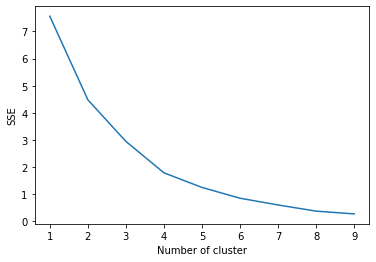

In [73]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(nyc_data_clustering_scaled_df)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

The elbow is the point where the number of cluster is 4 and so let's set number of clusters as 4

In [74]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_data_clustering_scaled_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 1, 1, 2, 1, 2, 2, 2, 1], dtype=int32)

In [75]:
kmeans.labels_

array([1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster.

In [76]:
# add clustering labels
nyc_data.insert(0, 'Cluster Labels', kmeans.labels_)
nyc_data.head()

,Cluster Labels,Postalcode,Population,Median household income,Asian percentage,Borough,Neighborhood,Latitude,Longitude,Number of Asian Restaurant
0,1,10022,30642,80406,6.58,Manhattan,Sutton Place,40.760280,-73.963556,1
1,2,10005,884,79517,22.85,Manhattan,Financial District,40.707107,-74.010665,0
2,1,10024,61414,78066,4.26,Manhattan,Upper West Side,40.787658,-73.977059,1
3,1,10028,44987,77565,5.01,Manhattan,Yorkville,40.775930,-73.947118,1
4,2,10128,59856,70031,6.68,Manhattan,Carnegie Hill,40.782683,-73.953256,0


Merge Asian restaurants rating to the nyc_data dataframe

In [77]:
nyc_data = nyc_data.merge(nyc_average_asian_rating,how='left',on="Postalcode")
nyc_data.head()

,Cluster Labels,Postalcode,Population,Median household income,Asian percentage,Borough,Neighborhood,Latitude,Longitude,Number of Asian Restaurant,Average Asian restaurant rating
0,1,10022,30642,80406,6.58,Manhattan,Sutton Place,40.760280,-73.963556,1,7.5
1,2,10005,884,79517,22.85,Manhattan,Financial District,40.707107,-74.010665,0,NaN
2,1,10024,61414,78066,4.26,Manhattan,Upper West Side,40.787658,-73.977059,1,8.7
3,1,10028,44987,77565,5.01,Manhattan,Yorkville,40.775930,-73.947118,1,8.1
4,2,10128,59856,70031,6.68,Manhattan,Carnegie Hill,40.782683,-73.953256,0,NaN


Finally, let's visualize the resulting clusters

In [78]:
import math
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rating in zip(nyc_data['Latitude'], nyc_data['Longitude'], nyc_data['Neighborhood'], nyc_data['Cluster Labels'], nyc_data['Average Asian restaurant rating']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ", "+ str(rating), parse_html=True)
    if math.isnan(rating):    
        fill1=False
    else:
        fill1=True
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=fill1,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

Let's take a look of Cluster 1

In [79]:
nyc_data.loc[nyc_data['Cluster Labels']==1].head()

,Cluster Labels,Postalcode,Population,Median household income,Asian percentage,Borough,Neighborhood,Latitude,Longitude,Number of Asian Restaurant,Average Asian restaurant rating
0,1,10022,30642,80406,6.58,Manhattan,Sutton Place,40.760280,-73.963556,1,7.50
2,1,10024,61414,78066,4.26,Manhattan,Upper West Side,40.787658,-73.977059,1,8.70
3,1,10028,44987,77565,5.01,Manhattan,Yorkville,40.775930,-73.947118,1,8.10
5,1,10017,16201,69273,15.01,Manhattan,Turtle Bay,40.752042,-73.967708,2,7.85
9,1,10011,46669,61986,6.13,Manhattan,"Chelsea,Flatiron",40.744035,-74.003116,1,8.70


Group the cluster by their label and calculate the mean of 3 key features

In [81]:
nyc_data_clustered = nyc_data[["Cluster Labels","Median household income","Asian percentage","Number of Asian Restaurant","Average Asian restaurant rating"]].groupby('Cluster Labels').mean().reset_index()
nyc_data_clustered

,Cluster Labels,Median household income,Asian percentage,Number of Asian Restaurant,Average Asian restaurant rating
0,0,31163.0,47.555000,1.000000,8.950000
1,1,71364.5,8.173333,1.333333,8.308333
2,2,60755.4,12.433000,0.000000,NaN
3,3,27244.3,3.624000,0.100000,NaN


# Result

## Cluster 0
- Median household income: medium
- Asian percentage: high
- Number of Asia restaurant: high
- Average Asian restaurant rating: high

## Cluster 1
- Median household income: high
- Asian percentage: low
- Number of Asia restaurant: high
- Average Asian restaurant rating: high

## Cluster 2
- Median household income: medium
- Asian percentage: medium
- Number of Asia restaurant: low/zero
- Average Asian restaurant rating: not applicable because there is no Asian restaurant

## Cluster 3
- Median household income: low
- Asian percentage: low
- Number of Asia restaurant: low
- Average Asian restaurant rating: not applicable because there are very few Asian restaurants in this cluster

# Observation and Recommendation

## Cluter 0

- Observation: This cluster has the highest Asian percentage but relatively low median household income. There is an Asian restaurant in very neighborhood with overall high rating.

- Recommendation: There is a stable demand of high quality Asian food with competitive price. The competition is very strong in this cluster and so newcomer may not want to set up new Asian restaurant in this cluster or they have to differentiate themselves significantly from the competitors. A highly specific of Asian cuisines could gain some market share.

## Cluster 1

- Observation: This cluster has the highest median household income but relatively low Asian percentage. On average, there is more than one restaurant with high rating in each neighborhood.

- Recommendation: Even though the Asian percentage is low, there is a constant demand of high quality Asia food. The demand in this cluster is lower than that in cluster 0 but the affordability is still high. The competition is also strong in this cluster but there is also opportunity for any newcomer considering the high median household income. The newcomer may consider a high class Asian restaurant with western style.

## Cluster 2

- Observation: There is no Asian restaurant in this cluster even with a medium Asian percentage.

- Recommendation: There could be a reason behind why there is no Asian restaurant in this cluster. This might be an opportunity for newcomer to open a this completely new market but this could also show that the interest to Asian cuisine is low. It could be a good idea to open a restaurant which requires a small investment to test the market.

## Cluster 3

- Observation: There is very little Asian with low affordability households in this cluster. Having said that, there is still a small amount of Asian restaurants.

- Recommendation: The potential market is very small with relatively low income household. A newcomer might face a weak competition but at the same time it has a small market to fulfill. Low price fast food shops could be a good option.

# Conclusion
This project has shown that we can apply Machine Learning method to analyze open data and come up with an actionable conclusion. As a data scientist, most of the time spent in a Data Science project is used to look for data and cleanse it. There is no 'the best' algorithm nor a single model fitting any business problem. A Data Scientist has to understand the limitation and the underlying meaning of the result. We have made a few assumptions before applying Machine Learning techniques. These assumptions are made based on our understanding of the real world data and the business problem. In order to be a successful Data Scientist, a cross-domains mindset is necessary to interpret the data and result. Going forward, we could expand the scope of this project to non-F&B industries to make strategic decisions.

This notebook was created by [William Tse](https://www.linkedin.com/in/william-tse-675b3228). I hope you get inspired by this project!